In [1]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage
import scipy
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage import morphology

# BEE DETECT

In [2]:
# Load all images from TRAIN
filenames = glob.glob('../TRAIN/*.jpg')
train_imgs = np.array([np.array(imageio.imread(filename)) for filename in filenames])
train_labels = np.array([np.array(np.genfromtxt(filename[:-3] + 'csv', delimiter=',')) for filename in filenames])

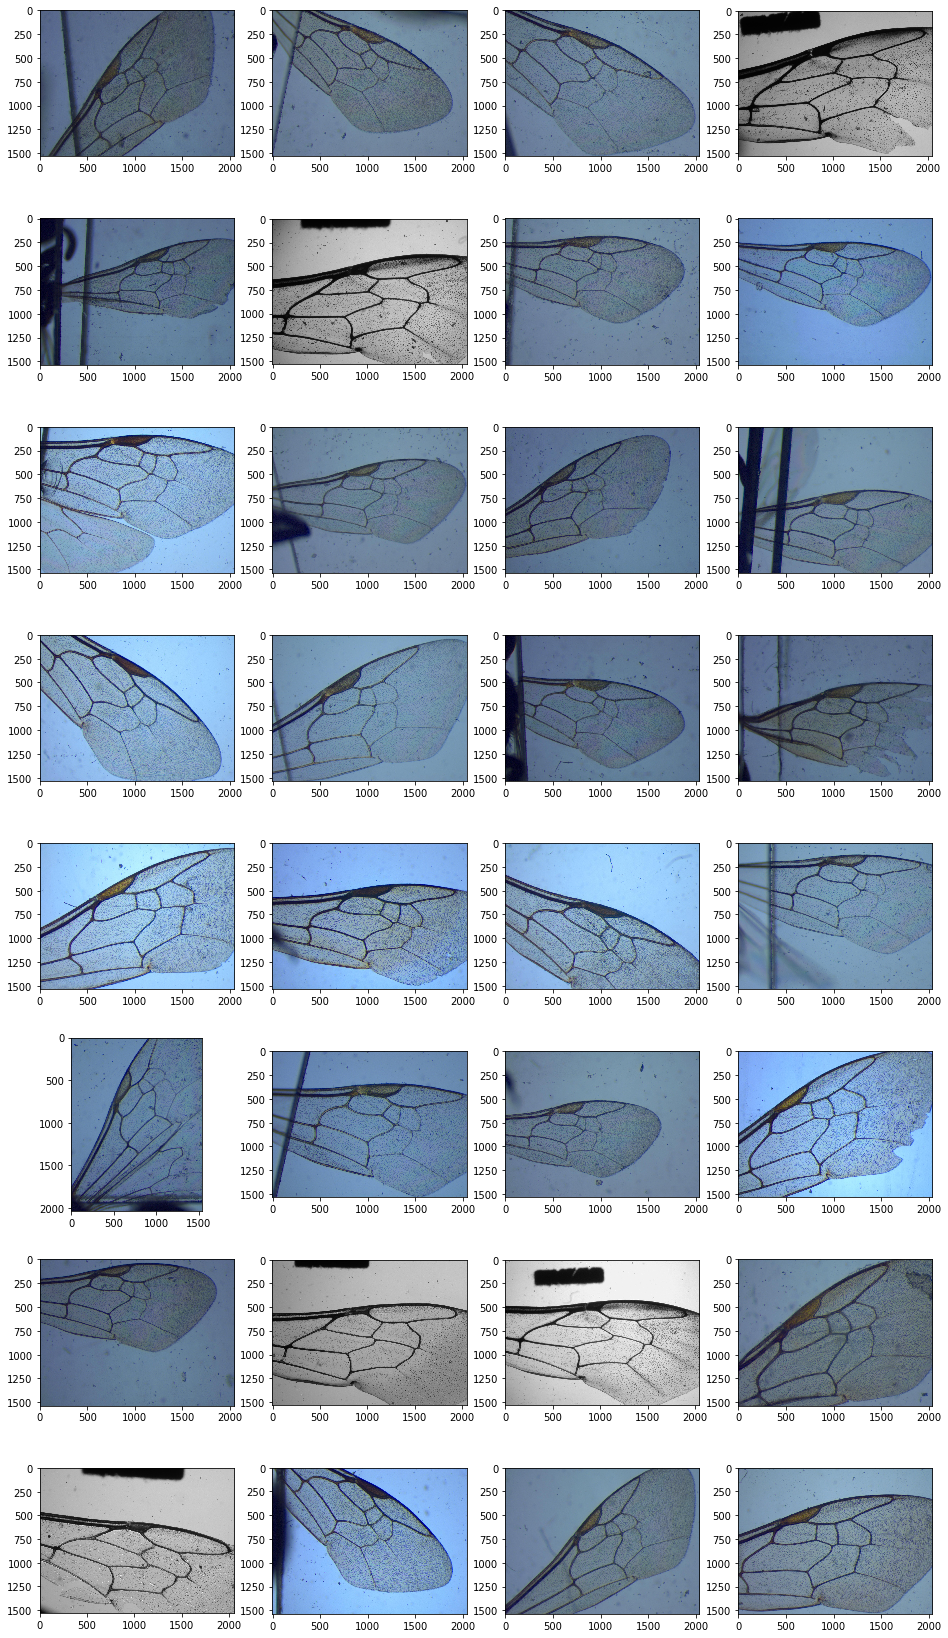

In [3]:
# Print all images from TRAIN
fig=plt.figure(figsize=(16, 30))
for i, img in enumerate(train_imgs):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(img)
plt.show()

In [4]:
# Load one image and CSV from TEST
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')




In [5]:
# Draw points from CSV on the image
def draw_points(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy,(int(point[1]), int(point[0])), 20, (255,255,0), -1)
    return img_copy

In [6]:
def draw_points_train(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy,(int(point[0]), int(point[1])), 20, (255,255,0), -1)
    return img_copy

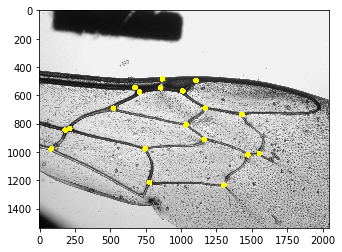

In [7]:
plt.imshow(draw_points(test_img, test_points))

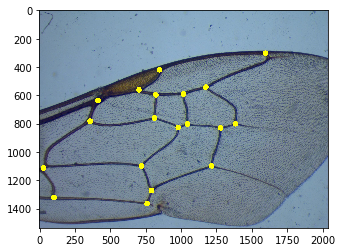

In [8]:
 plt.imshow(draw_points_train(train_imgs[i], train_labels[i]))

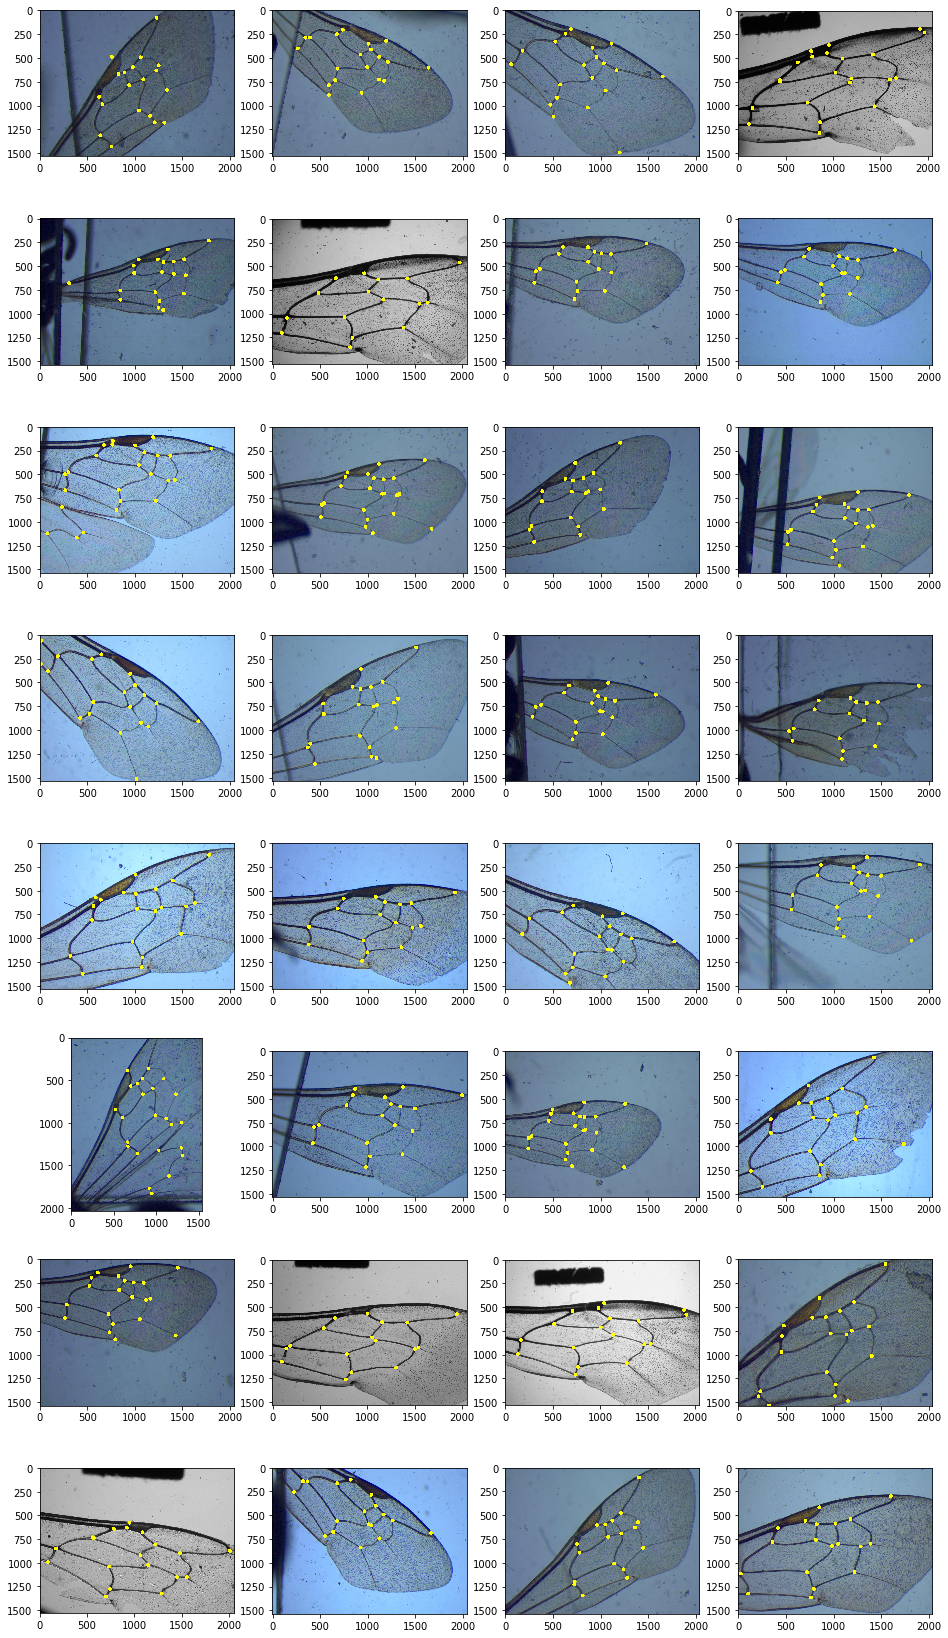

In [9]:
fig=plt.figure(figsize=(16, 30))
for i in range(0, len(train_imgs)):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points_train(train_imgs[i], train_labels[i]))

# TESTING EACH PREPROCESSING STEP

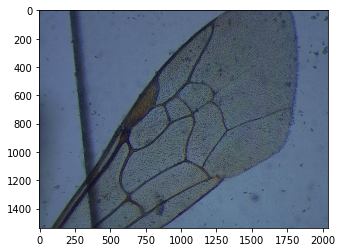

In [20]:
img = train_imgs[0].copy()
plt.imshow(img)

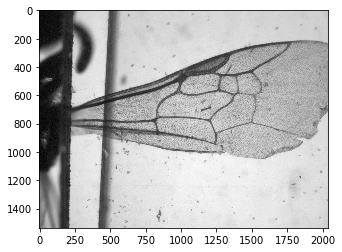

In [203]:
img = train_imgs[4].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = gray
plt.imshow(blur, cmap= 'gray')

In [ ]:
threshold_val = threshold_sauvola(blur, window_size=159)
bin_img = (blur > threshold_val).astype(np.uint8)
plt.imshow(bin_img, cmap= 'gray')

In [ ]:
import scipy.ndimage as nd

kernel = np.ones((5,5), np.uint8)
blur = cv2.bilateralFilter(bin_img, 10, 75, 75)
inv = np.invert(blur)
img_dilate = cv2.dilate(inv, kernel, iterations=6)
img_erode = cv2.erode(img_dilate, kernel, iterations=3)
plt.imshow(img_erode, cmap = 'gray')

In [ ]:
inv_img = np.invert(img_erode)
all_labels = skimage.measure.label(1 - skimage.morphology.remove_small_objects((1 - inv_img).astype(bool),min_size=5000))
plt.imshow(all_labels, cmap= 'nipy_spectral')

In [ ]:
kernel = np.ones((5,5), np.uint8)
img_dilate = cv2.dilate(all_labels.astype(np.uint8), kernel, iterations=6)
plt.imshow(img_dilate, cmap= 'nipy_spectral')

# PREPROCESSING FUNCTION

In [225]:
def process3(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_val = threshold_sauvola(gray, window_size=159)
    bin_img = (gray > threshold_val).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    blur = cv2.bilateralFilter(bin_img, 10, 75, 75)
    inv = np.invert(blur)
    img_dilate = cv2.dilate(inv, kernel, iterations=6)
    img_erode = cv2.erode(img_dilate, kernel, iterations=3)
    inv_img = np.invert(img_erode)
    all_labels = skimage.measure.label(1 - skimage.morphology.remove_small_objects((1 - inv_img).astype(bool),min_size=5000))
    kernel = np.ones((5,5), np.uint8)
    img_dilate = cv2.dilate(all_labels.astype(np.uint8), kernel, iterations=6) 
    return img_dilate

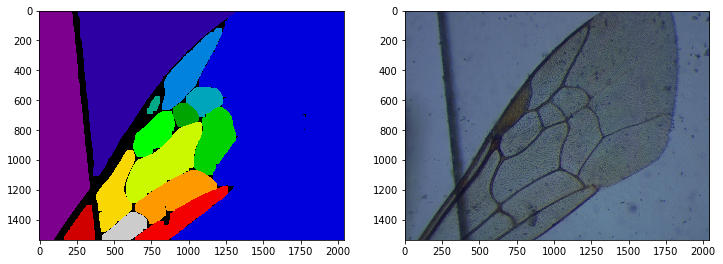

In [226]:
fig=plt.figure(figsize=(12, 20))
img = train_imgs[0].copy()
ws = process3(img)
fig.add_subplot(1, 2, 1)
plt.imshow(ws, cmap='nipy_spectral')
fig.add_subplot(1, 2, 2)
plt.imshow(img)

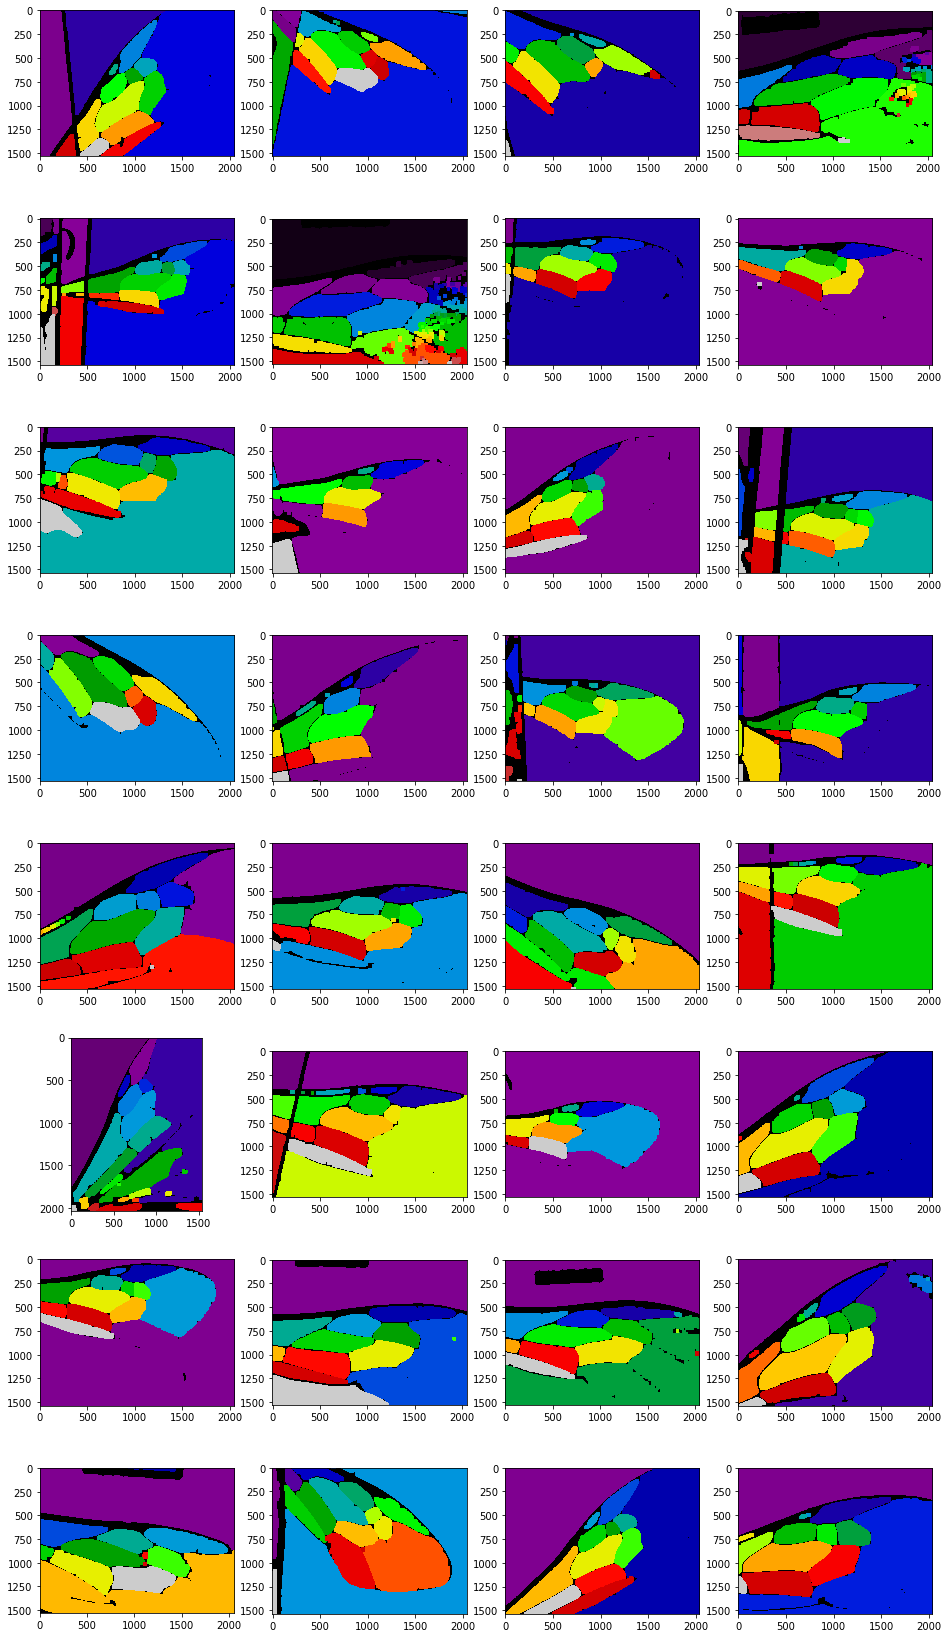

In [227]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process3(img)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(ws, cmap='nipy_spectral')
plt.show()

# Intersections Detection

In [228]:
def intersect(img):
    fig=plt.figure(figsize=(10, 10))

    height, width = img.shape
    step = 60
    intersects = np.full(img.shape, 0)
    for i in range(0, height-step, step//2):
        for j in range(0, width-step, step//2):
            colors = set()
            for k in range(i, i+step):
                for l in range(j, j+step):
                    pixel = img[k][l]
                    if pixel != -1 and pixel not in colors:
                        colors.add(pixel)
            if len(colors) >= 4:
                intersects[i+step//2][j+step//2] = 1
                
                
    # mean
    step = 80
    res = [] # list of tuple
    intersects2 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects2[mean[0]][mean[1]] = 1
                res.append(mean)
            else:
                for point in pts:
                    intersects2[point[0]][point[1]] = 1
                    res.append(point)

    fig.add_subplot(1, 2, 1)
    plt.imshow(draw_points(img, res))         
    
    # mean
    step = 100
    res = [] # list of tuple
    intersects3 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects2[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects3[mean[0]][mean[1]] = 1
                res.append(mean)
            else:
                for point in pts:
                    intersects3[point[0]][point[1]] = 1
                    res.append(point)
                 
   
    fig.add_subplot(1, 2, 2)
    plt.imshow(draw_points(img, res))
    plt.show()
    

    step = 80
    res = [] # list of tuple
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects3[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                res.append((sum_y // len(pts), sum_x // len(pts)))
            else:
                for point in pts:
                    res.append(point)
    return res

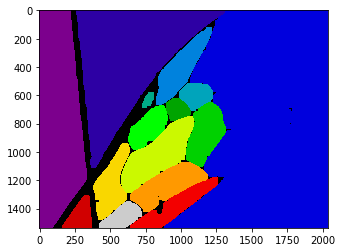

In [229]:
img = train_imgs[0].copy()
ws = process3(img)
plt.imshow(ws, cmap='nipy_spectral')

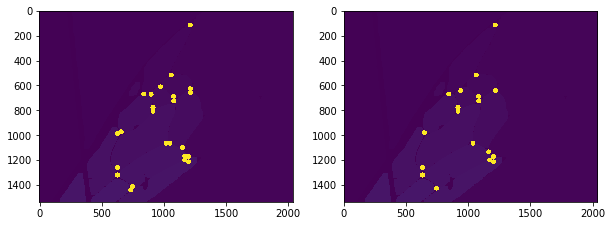

In [ ]:
points = intersect(ws)

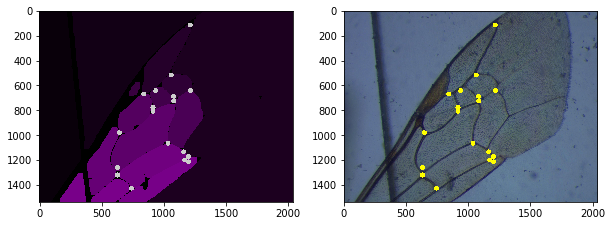

In [ ]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(ws, points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(img, points))

plt.show()

# Detection on train images

<Figure size 1152x2160 with 0 Axes>

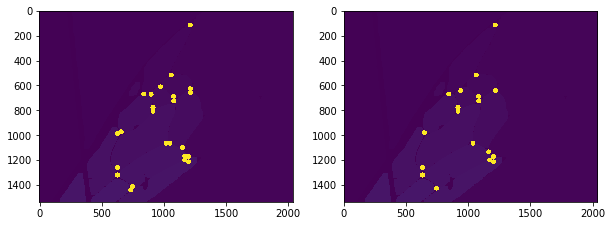

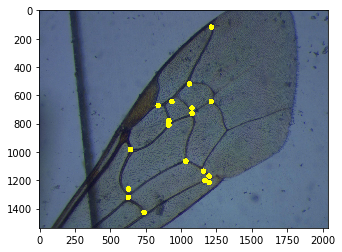

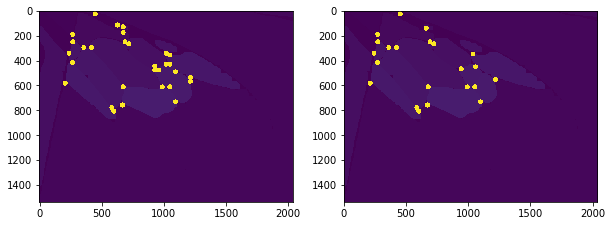

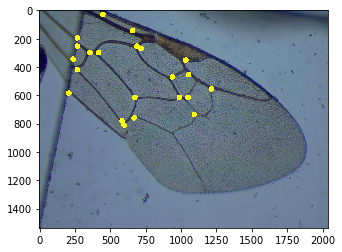

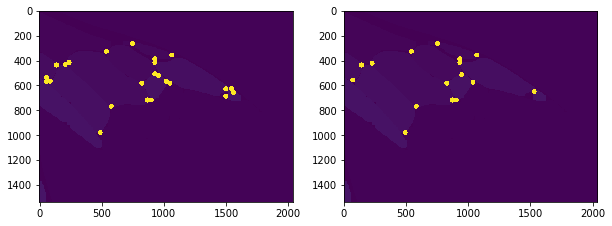

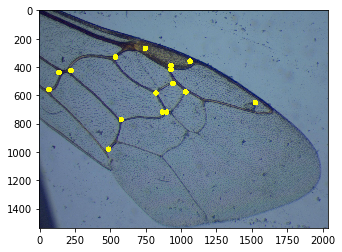

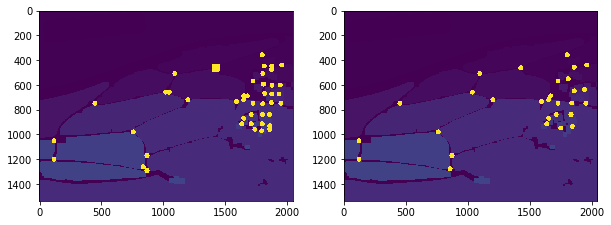

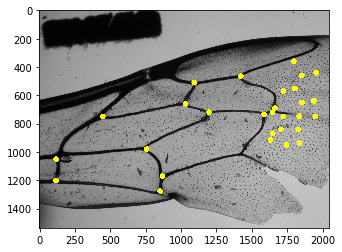

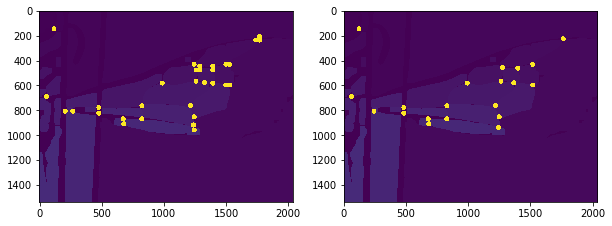

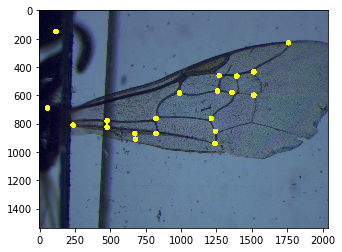

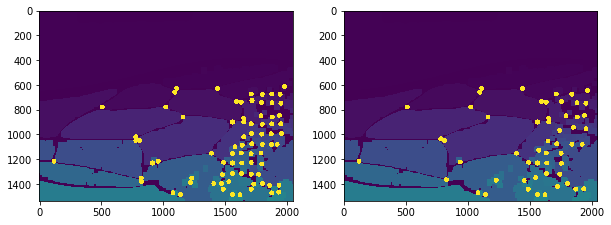

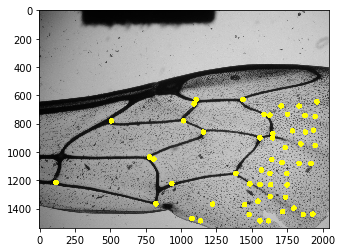

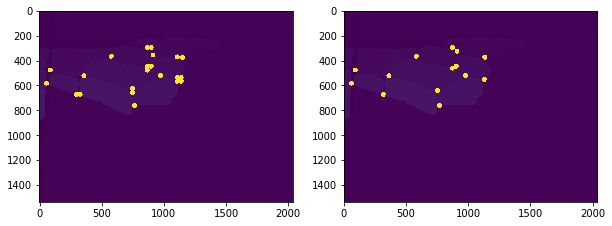

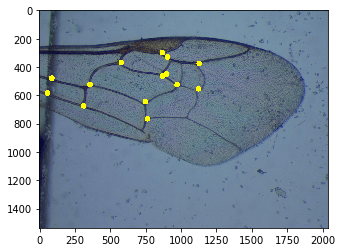

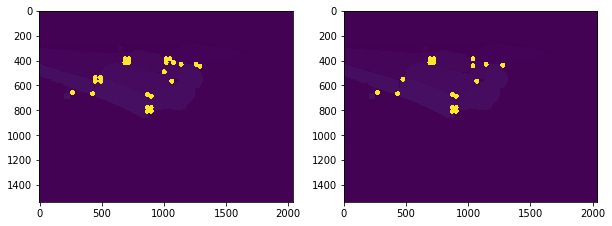

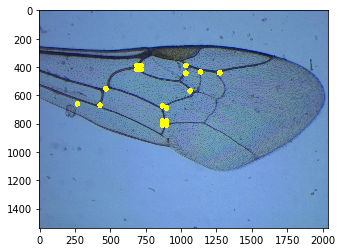

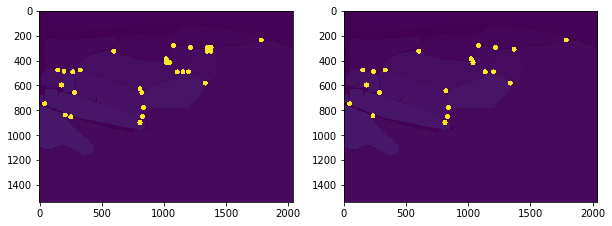

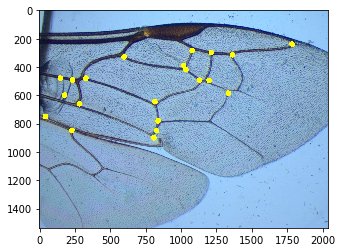

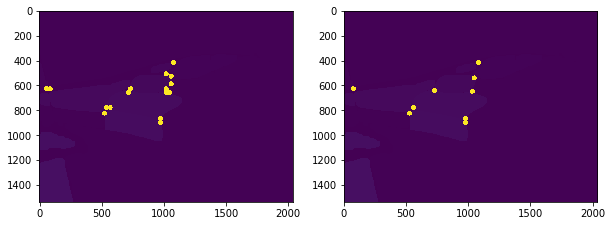

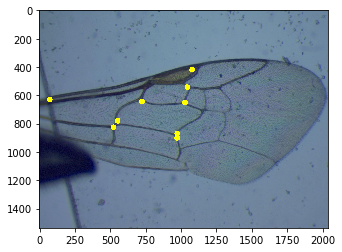

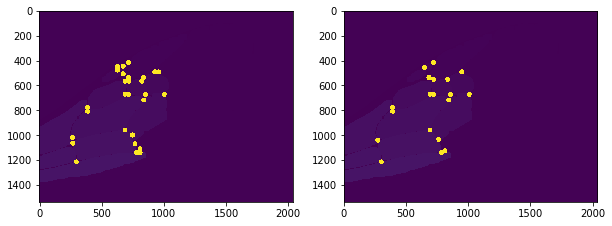

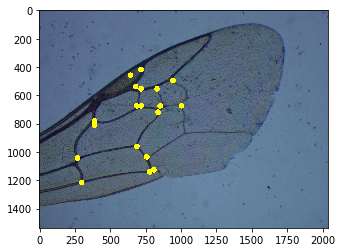

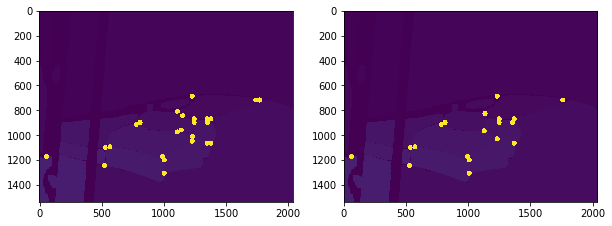

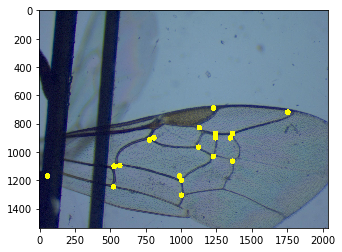

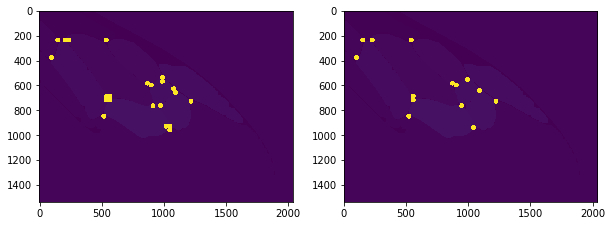

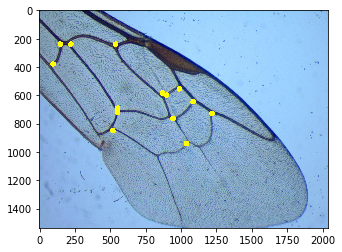

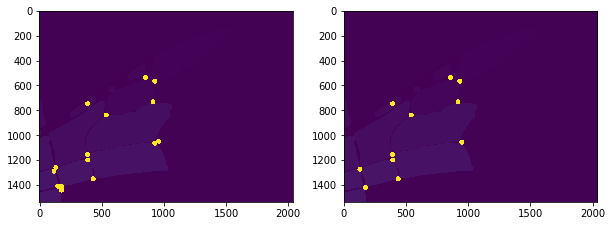

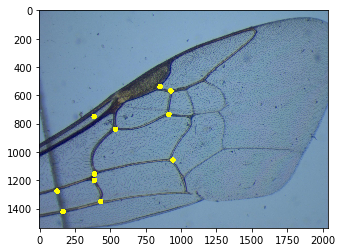

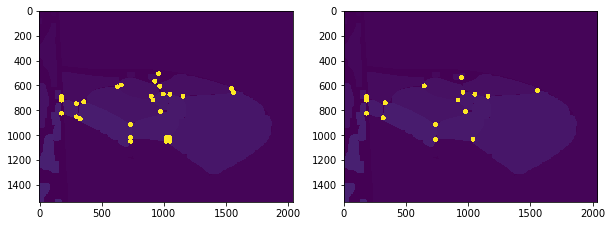

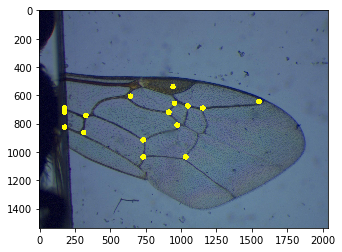

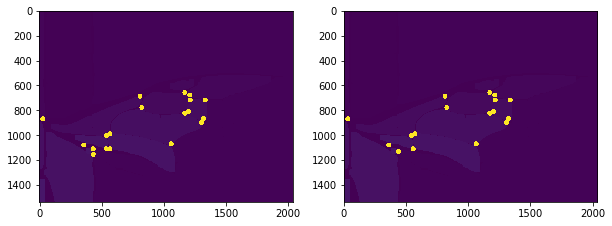

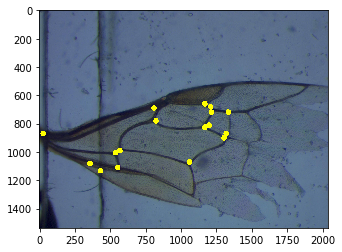

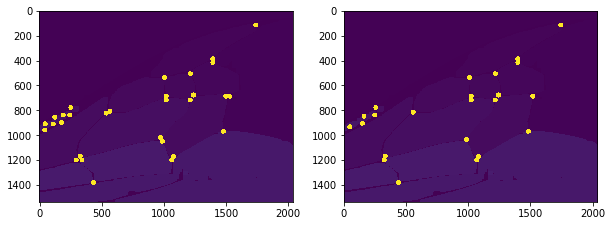

In [ ]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process3(img)
    points = intersect(ws)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(img, points))
plt.show()


# Detection on test image

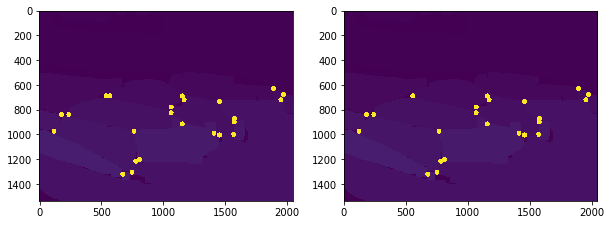

In [129]:
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')
ws = process3(test_img)
points = intersect(ws)

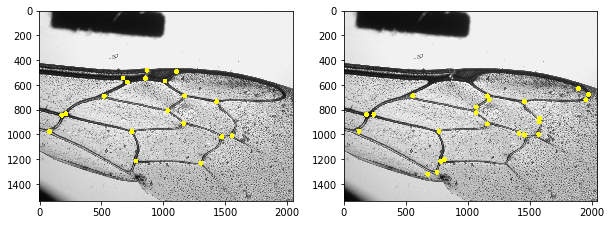

In [130]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(test_img, test_points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(test_img, points))

plt.show()

# Compute score